In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [6]:

dataframes = []

# Loop through the range of years
for year in range(1999, 2024):
    df = pd.read_csv(f'../DATA/{year}.csv')
    df = df[df['EVENT_TYPE'] == 'Tornado']
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('../DATA/combined_data.csv', index=False)

combined_df.head()


C:\Users\thabe\AppData\Local\Temp\ipykernel_1328\3884184908.py:5: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../DATA/{year}.csv')


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,199901,1,2302,199901,1,2305,1500528,5681689,LOUISIANA,22.0,...,5.0,NNE,KORAN,32.48,-93.47,32.48,-93.43,NaN,"Tornado formed along a squall line notch, in t...",PDC
1,199901,1,2305,199901,1,2323,1075854,5681690,LOUISIANA,22.0,...,1.0,WNW,SIBLEY,32.50,-93.45,32.53,-93.32,NaN,Damage consisted of a 20 horse stall and build...,PDC
2,199904,26,1212,199904,26,1220,2405384,5691121,TEXAS,48.0,...,4.0,NE,NACOGDOCHES,31.62,-94.70,31.65,-94.62,NaN,North to south oriented multi-cellular squall ...,PDC
3,199907,30,1709,199907,30,1709,2411493,5715547,MINNESOTA,27.0,...,NaN,NaN,BELLE PLAINE,44.63,-93.77,44.63,-93.77,NaN,Roofs partially taken off two downtown busines...,PDC
4,199907,30,1720,199907,30,1720,2411493,5715548,MINNESOTA,27.0,...,NaN,NaN,LYDIA,44.65,-93.50,44.65,-93.50,NaN,Mostly touched down in open field near Hwy 13 ...,PDC


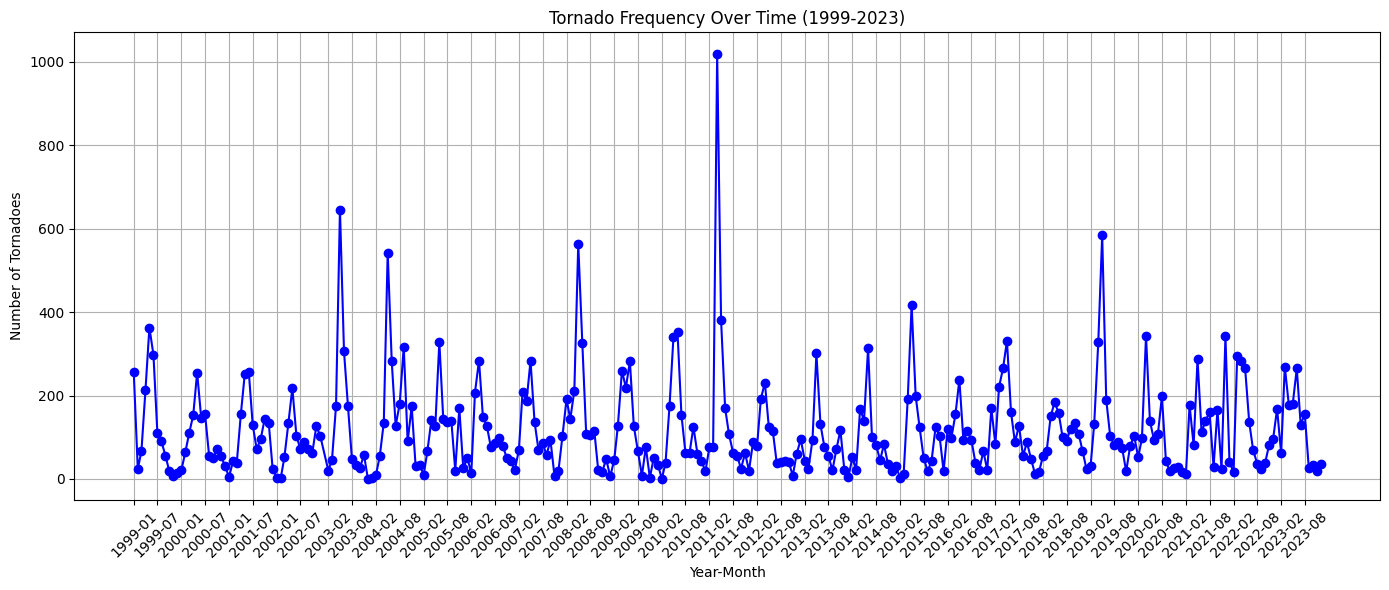

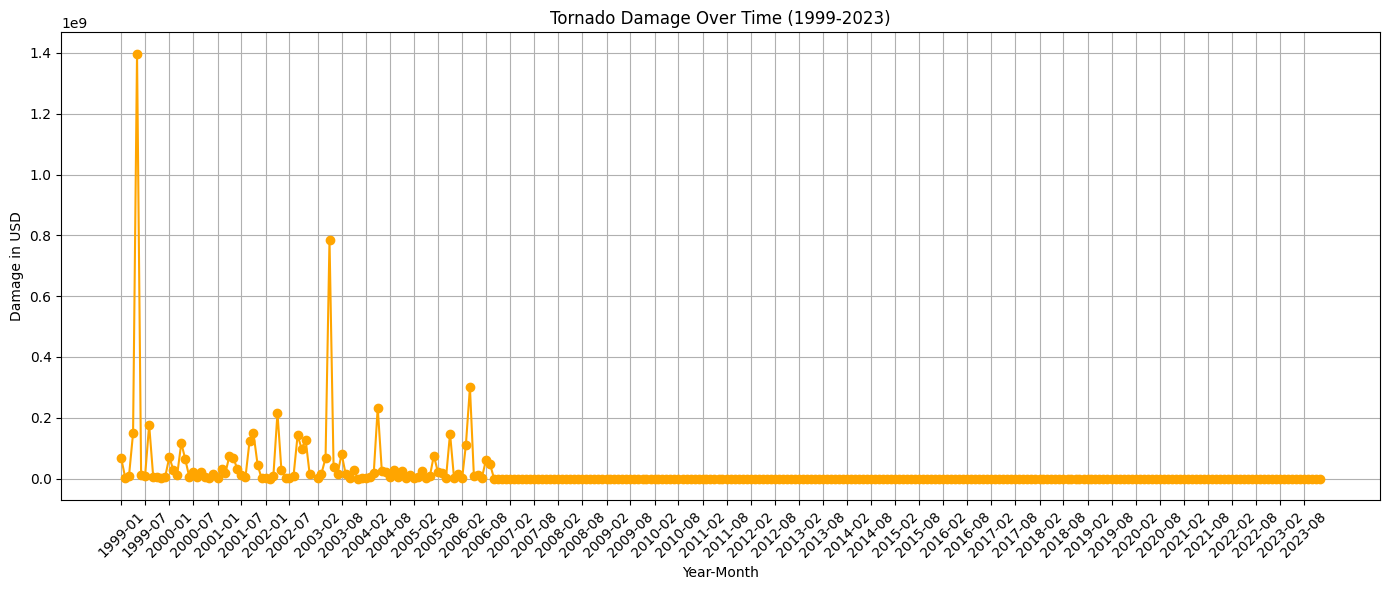

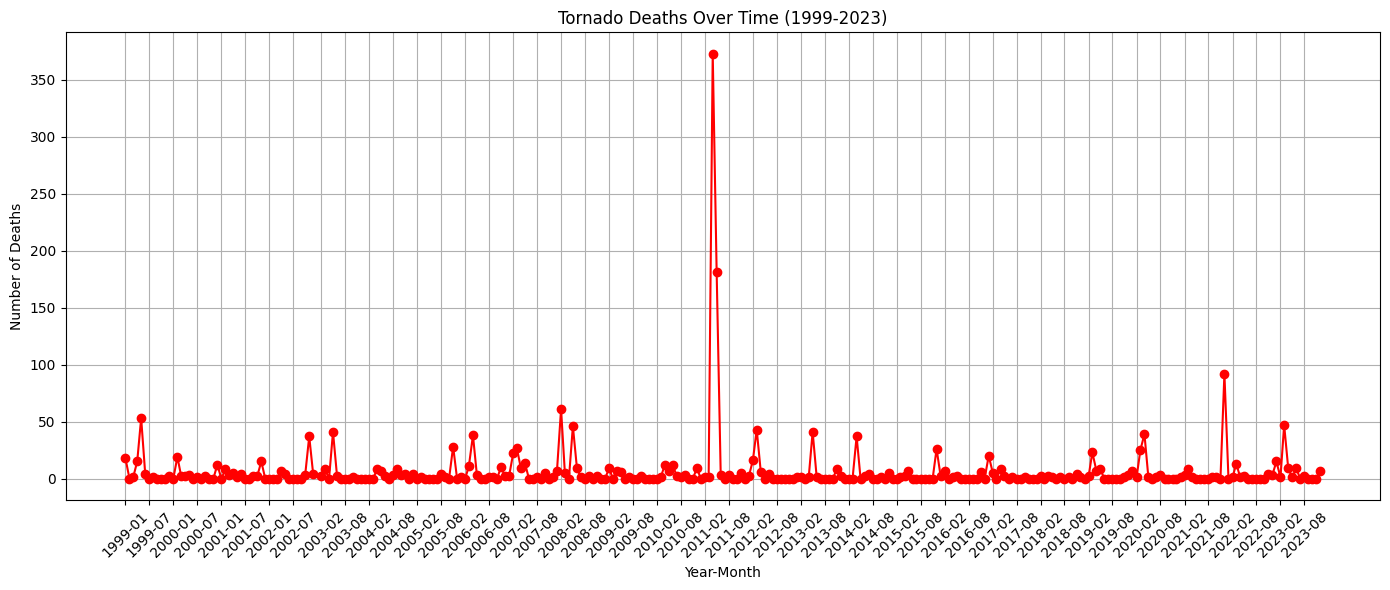

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the BEGIN_YEARMONTH column to a datetime format for easier plotting
combined_df['BEGIN_YEARMONTH'] = pd.to_datetime(combined_df['BEGIN_YEARMONTH'].astype(str), format='%Y%m')
filtered_df = combined_df

# Define a function to plot with years and their months
def plot_with_specific_years(x_values, y_values, title, xlabel, ylabel, color='blue'):
    plt.figure(figsize=(14, 6))  # Increase figure size to give more space
    plt.plot(x_values, y_values, marker='o', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Set x-ticks for every third month
    ax = plt.gca()
    ax.set_xticks(x_values[::6])  # Show every third month to reduce clutter
    ax.set_xticklabels(x_values[::6].strftime('%Y-%m'), rotation=45)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot 1: Tornado Frequency over Time (1999-2023)
tornado_frequency = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH']).size()
plot_with_specific_years(tornado_frequency.index, tornado_frequency.values,
                         title='Tornado Frequency Over Time (1999-2023)',
                         xlabel='Year-Month', ylabel='Number of Tornadoes')

# Plot 2: Tornado Damage over Time (1999-2023)
filtered_df['DAMAGE_PROPERTY'] = pd.to_numeric(filtered_df['DAMAGE_PROPERTY'].str.replace('K', '000').str.replace('M', '000000'), errors='coerce')
tornado_damage = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH'])['DAMAGE_PROPERTY'].sum()
plot_with_specific_years(tornado_damage.index, tornado_damage.values,
                         title='Tornado Damage Over Time (1999-2023)',
                         xlabel='Year-Month', ylabel='Damage in USD', color='orange')

# Plot 3: Tornado Deaths over Time (for 1999-2023)
filtered_df['TOTAL_DEATHS'] = filtered_df['DEATHS_DIRECT'] + filtered_df['DEATHS_INDIRECT']
tornado_deaths = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH'])['TOTAL_DEATHS'].sum()
plot_with_specific_years(tornado_deaths.index, tornado_deaths.values,
                         title='Tornado Deaths Over Time (1999-2023)',
                         xlabel='Year-Month', ylabel='Number of Deaths', color='red')



In [9]:
#Test to ensure that data is stationary
freq = pd.DataFrame(tornado_frequency)
freq.columns = ['Value']
result = adfuller(freq['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#P-value < 0.05, fail to reject hypothesis that it is stationary


ADF Statistic: -4.18031010353507
p-value: 0.0007113333707923306


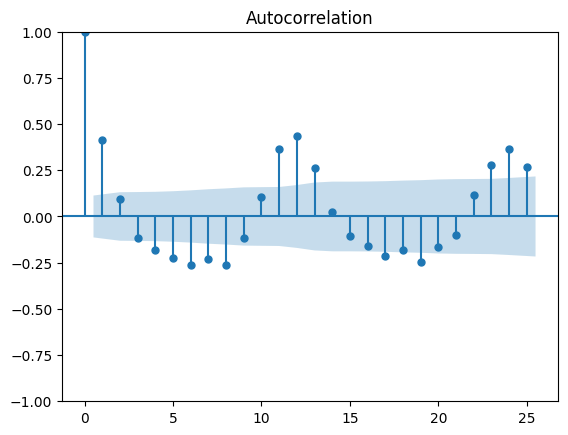

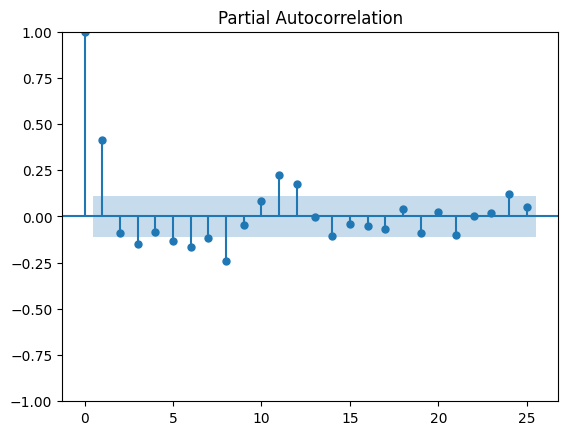

In [10]:
#Plot ACF and PACF to determine order of AR and MA
plot_acf(freq)
plot_pacf(freq)
plt.show()

In [12]:
#80/20 train/test split
train=freq.iloc[:-60]
test=freq.iloc[-60:]
print(train.shape, test.shape)

(239, 1) (60, 1)


In [28]:
#Fit Model and create range for predictions
model = ARIMA(train['Value'], order=(12, 1, 11))
model_fit = model.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_fit.predict(start=start, end=end, typ='levels')

c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

np.float64(9380.015795456067)

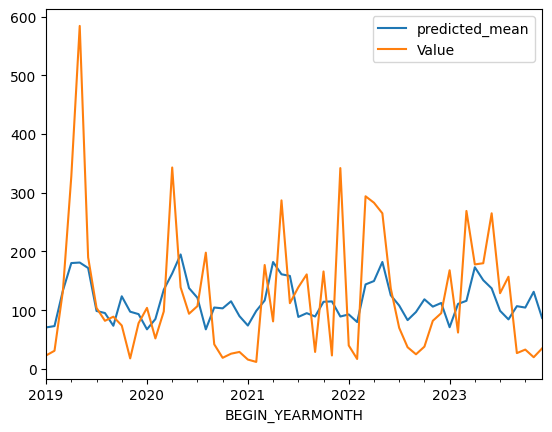

In [33]:
#ARIMA predictions vs actual values. MSE of 9380.02
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE

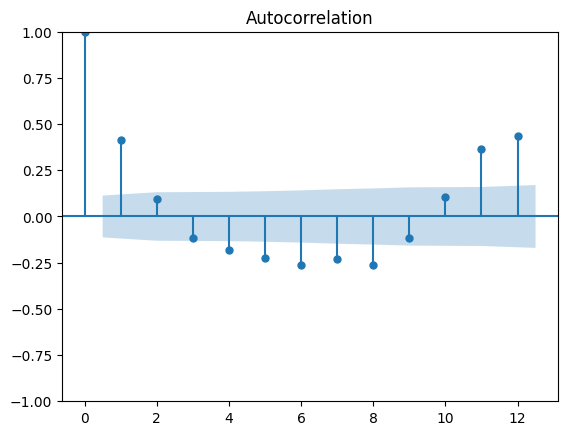

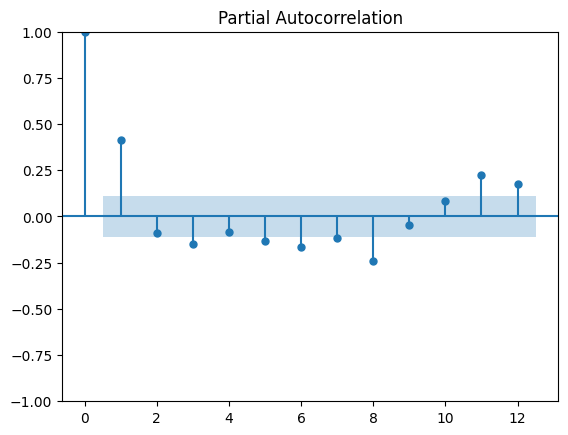

In [34]:
##Plot ACF and PACF to determine order of AR and MA
plot_acf(freq, lags = 12)
plot_pacf(freq, lags = 12)
plt.show()

In [39]:
#Fit Model and create range for predictions, using the same range for train / test
model_sarima = SARIMAX(train['Value'], 
                       order=(1, 0, 1),          
                       seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit()
start = len(train)  
end = len(train) + len(test) - 1  
pred = model_sarima_fit.predict(start=start, end=end, typ='levels')



c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\thabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

np.float64(8051.062473164242)

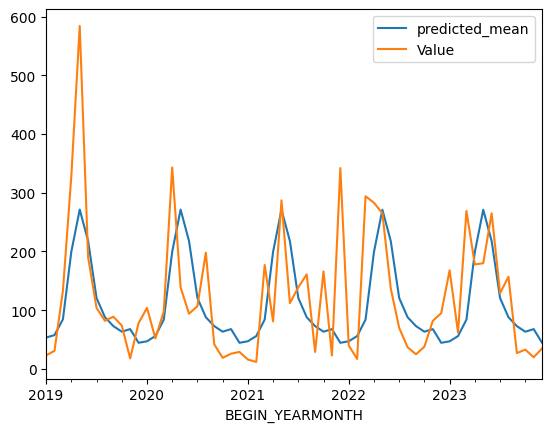

In [40]:
#SARIMA predictions vs actual values. MSE of 8051.06
#Substantially preferred to ARIMA, better at capturing seasonality
pred.index = test.index
pred.plot(legend=True)
test['Value'].plot(legend=True)
MSE = mean_squared_error(pred,test['Value'])
MSE